In [1]:
# some setup code
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
from time import time

# A bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline 
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/seo/anaconda3/envs/cnnPy3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


function to load data (RGB)

file structure:

```sh
NeuralNetwork_RGB.ipynb
./data:
    labels.csv
    posts_filtered.csv
    rgbdata50.csv
```


In [4]:
def load_data():
    start = time()
    labels = np.loadtxt('data/csv_4/labels_lf.csv', delimiter=',', dtype=np.float32)
    labels = np.minimum(1.0, labels)
    labels.shape = (-1,1)

    rgb = np.loadtxt('data/csv_4/rgbdata20.csv', delimiter=',', dtype=np.float32)
    rgb.shape = (-1, 3, 20, 20)
    print('Job completed in: {} seconds'.format(time()-start))
    return rgb, labels

rgb, labels = load_data()
nb_classes = 1
print('rgb shape', rgb.shape)
print('labels shape', labels.shape)

Job completed in: 13.24473786354065 seconds
rgb shape (11560, 3, 20, 20)
labels shape (11564, 1)


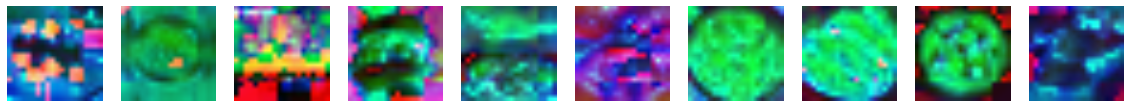

In [5]:
###RGB to HSV
plt.figure(figsize=(20, 4))
n = 10
for i in range(n):
    img = rgb[i]
    img = np.transpose(img, (1, 2, 0))
    img = rgb_to_hsv(img)
    
    ax = plt.subplot(1, n, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(img)


plt.show()

In [7]:
tmp = np.transpose(rgb, (0, 2, 3, 1))
hsv = rgb_to_hsv(tmp)

### Change label type from normalized popularity to popularVSunpopular

In [178]:
# CHOICE 1: MULTI CLASS
nb_classes = 2
label_md = np.copy(labels)

temp = []
for label in label_md:
    if label < 0.5:
        temp.append([1,0])
    else:
        temp.append([0,1])

label_md = np.array(temp)
label_md.shape = (-1,nb_classes)
print(label_md.shape)
# print(label_2d[:100])

(12380, 2)


In [6]:
# CHOICE 2: SINGLE CLASS
nb_classes = 1
label_md = np.copy(labels)
label_md.shape = (-1,nb_classes)

In [8]:
def divide_data(hsv, labels, data_size=None, train_ratio=0.9):
    '''Randomly select given number of data and divide into training set and test set'''
    data_size_max = labels.shape[0]
    data_size = data_size_max if data_size is None else data_size
    train_size = int(np.floor(train_ratio * data_size))

    mask = list(range(data_size_max))
    mask = np.random.choice(mask, data_size, replace=False)
    hsv = hsv[mask]/255
    labels = np.minimum(labels[mask], 1.0)
    X_train = hsv[:train_size]
    y_train = labels[:train_size]
    X_test = hsv[train_size:]
    y_test = labels[train_size:]

    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = divide_data(hsv, label_md, 
#                                                    data_size=1000, 
                                                   train_ratio=10/11) # 10/11 this ratio allows train = 10*test
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

# print('X_train', X_train[:2])
# print('y_train', y_train[:2])

IndexError: index 11560 is out of bounds for axis 0 with size 11560

In [27]:
def buildModel(shape):
    model = Sequential()
    print(shape)
    model.add(Conv2D(32, (3, 3),
                     padding='same',
                     activation='relu',
                     data_format="channels_last",
                     input_shape=shape))
    model.add(Conv2D(32, (3, 3),
                     data_format="channels_last",
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (4, 4),
                     data_format="channels_last",
                     activation='relu'))
    model.add(Conv2D(32, (3, 3),
                     data_format="channels_last",
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, 
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes,
                    activation='relu'))
    
    rmsprop = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
    sgd = SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)
    def abs_diff(y_true, y_pred):
        return np.absolute(y_true - y_pred)
    model.compile(optimizer=rmsprop,
                  loss='mse',
                  metrics=[abs_diff, 'mse'])

    return model

input_shape = X_train.shape[1:]
model = buildModel(input_shape)
print(model)


(50, 50, 3)


In [22]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11254, 50, 50, 3) (1126, 50, 50, 3) (11254, 1) (1126, 1)


In [28]:
hist = model.fit(X_train, y_train,
                batch_size=32, 
                epochs=2,
                verbose=1,
                validation_data=(X_test, y_test))
          
score = model.evaluate(X_test, y_test)


print('Validation loss:', round(score[0],2))
print('Validation accuracy:', round(100*score[1],2), "%")

Train on 11254 samples, validate on 1126 samples
Epoch 1/2
11254/11254 [==============================] - 124s - loss: 0.0192 - abs_diff: 0.0979 - mean_squared_error: 0.0192 - val_loss: 0.0171 - val_abs_diff: 0.0885 - val_mean_squared_error: 0.0171
Epoch 2/2
1120/1126 [============================>.] - ETA: 0sValidation loss: 0.02
Validation accuracy: 8.81 %


In [29]:
print(keras.__version__)
x = np.array([1,23,4,5,6,6,423,2])
print(np.minimum(1, 4.5))
print(model.metrics_names)

2.0.4
1.0
['loss', 'acc']


### Plot Predicted values vs Real values

There are almost no correlation between RGB and lables

In [29]:
y_prediction = model.predict(X_test, verbose=1)
#y_test = y_test

1120/1126 [============================>.] - ETA: 0s

(1126,)
[ 0.20866774  0.53941911  0.33333334  0.09231853  0.08243728  0.00544186
  0.15789473  0.00926739  0.1632653   0.1564482 ]
[ 0.12728027  0.12728193  0.12729605  0.12727916  0.12728691  0.12726173
  0.12728193  0.12724948  0.12728193  0.1272448 ]


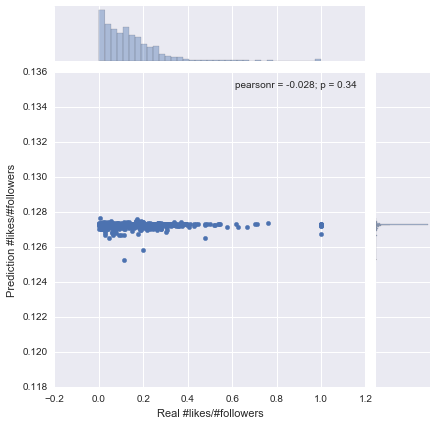

In [30]:
y_test.shape = (-1)
y_prediction.shape = (-1)
print(y_test.shape)
print(y_test[0:10])
print(y_prediction[0:10])
data = np.array([y_prediction, y_test]).T
# data.shape = (2, -1)
# plt.title('CNN on RGB of Dataset#1')
df = pd.DataFrame(data, columns=["Prediction #likes/#followers", "Real #likes/#followers"])
sns.jointplot(x="Real #likes/#followers", y="Prediction #likes/#followers", data=df);

[[ 0.99607074  0.        ]
 [ 0.99630129  0.        ]
 [ 0.9946174   0.        ]
 [ 0.99550617  0.        ]
 [ 0.99511003  0.        ]
 [ 0.99618655  0.        ]
 [ 0.99635667  0.        ]
 [ 1.01204574  0.        ]
 [ 0.99408031  0.        ]
 [ 0.99862236  0.        ]
 [ 0.99354082  0.        ]
 [ 0.99712449  0.        ]
 [ 0.99543506  0.        ]
 [ 1.00232792  0.        ]
 [ 0.9962799   0.        ]
 [ 0.99890953  0.        ]
 [ 0.99655253  0.        ]
 [ 0.99354082  0.        ]
 [ 0.99358368  0.        ]
 [ 0.99466103  0.        ]
 [ 0.99866933  0.        ]
 [ 0.99394405  0.        ]
 [ 0.99362165  0.        ]
 [ 0.99354082  0.        ]
 [ 0.99962443  0.        ]
 [ 1.00704741  0.        ]
 [ 0.99336082  0.        ]
 [ 0.99446476  0.        ]
 [ 0.99700862  0.        ]
 [ 0.99679905  0.        ]
 [ 0.99355215  0.        ]
 [ 0.99357045  0.        ]
 [ 0.99357486  0.        ]
 [ 1.00479484  0.        ]
 [ 0.99758303  0.        ]
 [ 0.99356425  0.        ]
 [ 1.00010443  0.        ]
 

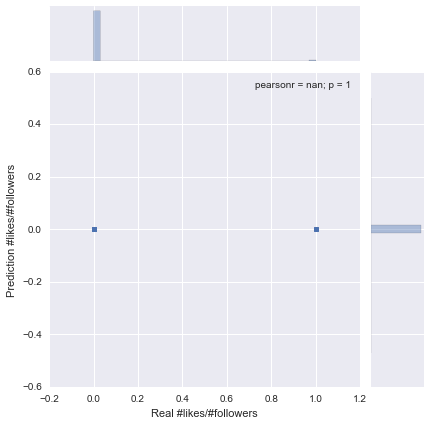

In [186]:
y_prediction.shape = y_test.shape = (-1, nb_classes)
y_test_int = []
y_pred_int = []
def max_idx(arr):
    max_i = 0
    max_val = 0
    for i in range(len(arr)):
        if arr[i] > max_val:
            max_val = arr[i]
            max_i = i
    return max_i, max_val

# print(y_prediction[:50])
for i in range(max(y_test.shape)):
    t = y_test[i]
    y_test_int.append(max_idx(t)[0])
    p = y_prediction[i]
    y_pred_int.append(max_idx(p)[0])

y_test_int = np.array(y_test_int)
y_pred_int = np.array(y_pred_int)

y_test_int.shape = (-1)
y_pred_int.shape = (-1)
# print(y_test.shape)
# print(y_test[0:10])
data = np.array([y_pred_int, y_test_int]).T
df = pd.DataFrame(data, columns=["Prediction #likes/#followers", "Real #likes/#followers"])
sns.jointplot(x="Real #likes/#followers", y="Prediction #likes/#followers", data=df);

In [112]:
#Input an image, resize as 50x50, output RGB data
# from PIL import Image
# img = Image.open('images/12403.jpg')
# img_size = 50
# img.show()

# img = img.resize((img_size,img_size),Image.ANTIALIAS)
# pixels = np.array(img.getdata(), dtype=int)/255
# model.predict(pixels, batch_size=32, verbose=1)